In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-07 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.13.1
matplotlib 3.1.0
imblearn 0.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt

# Load datasets

In [3]:
datasets = pd.DataFrame()
for i in range(1,5):
    print(i)
    dump = pd.read_csv("../../data/sample ({}).csv".format(i), engine='python',names=['chat','label'])
    datasets = pd.concat([datasets, dump])
datasets.head()

1
2
3
4


,chat,label
0,자기잘못인거알면 중고딩도 먼저사과하는걸아는데,0
1,싹둑이 채팅창 관리 중입니다,0
2,싹둑이 채팅창 관리 중입니다,0
3,어제 어글 아직도 가? 개인적으로 사과하셨대 그만해 칭구들앙,0
4,케읍이 뭔데요 무슨사건있엇음?,0


In [4]:
datasets.reset_index(drop=True,inplace=True)

In [5]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 2 columns):
chat     3500 non-null object
label    3500 non-null int64
dtypes: int64(1), object(1)
memory usage: 54.8+ KB


In [6]:
datasets.label = datasets.label.astype('int')

In [7]:
len(datasets[datasets.label ==1])/ len(datasets[datasets.label ==0]) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향ㅠㅠ

0.16163292399601725

# Tokenize
## 형태소분석

In [8]:
morp = Okt()

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [9]:
morped = [morp.pos(_, norm=True, join=True) for _ in tqdm(datasets.chat)] # Stemming은 하지 않는다.

100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:24<00:00, 141.68it/s]


In [10]:
morped[:5]

[['자기/Noun',
  '잘못/Noun',
  '인거/Josa',
  '알/Noun',
  '면/Josa',
  '중/Noun',
  '고딩/Noun',
  '도/Josa',
  '먼저/Noun',
  '사과/Noun',
  '하/Suffix',
  '는/Josa',
  '걸아는데/Verb'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['싹둑/Noun',
  '이/Josa',
  '채팅/Noun',
  '창/Noun',
  '관리/Noun',
  '중/Noun',
  '입니다/Adjective'],
 ['어제/Noun',
  '어글/Noun',
  '아직도/Adverb',
  '가/Verb',
  '?/Punctuation',
  '개인/Noun',
  '적/Suffix',
  '으로/Josa',
  '사과/Noun',
  '하셨대/Verb',
  '그만해/Adjective',
  '칭구들앙/Noun'],
 ['케읍/Noun',
  '이/Josa',
  '뭔/Modifier',
  '데/Noun',
  '요/Josa',
  '무슨/Modifier',
  '사건/Noun',
  '있/Adjective',
  '엇음/Noun',
  '?/Punctuation']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [11]:
vocab_size = 5000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

고빈도 단어:
형/Suffix :  724
이/Josa :  706
샤/Noun :  587
나왔/Verb :  562
브베/Noun :  442
창/Noun :  420
채팅/Noun :  417
중/Noun :  408
입니다/Adjective :  408
싹둑/Noun :  407

단어 사전:
0 <PAD>
1 <OOV>
2 형/Suffix
3 이/Josa
4 샤/Noun
5 나왔/Verb
6 브베/Noun
7 창/Noun
8 채팅/Noun
9 중/Noun

단어 사전 크기:  3421


In [12]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['자기/Noun', '잘못/Noun', '인거/Josa', '알/Noun', '면/Josa', '중/Noun', '고딩/Noun', '도/Josa', '먼저/Noun', '사과/Noun', '하/Suffix', '는/Josa', '걸아는데/Verb']
문자 -> 숫자:  [234, 781, 782, 381, 293, 9, 1292, 58, 1293, 235, 93, 60, 1294]
숫자 -> 문자:  자기/Noun 잘못/Noun 인거/Josa 알/Noun 면/Josa 중/Noun 고딩/Noun 도/Josa 먼저/Noun 사과/Noun 하/Suffix 는/Josa 걸아는데/Verb


# Padding

In [13]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 20
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

# Data Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

print("train_inputs shape: ", X_train.shape)
print("test_inputs shape: ", X_test.shape)
print("train_labels shape: ", y_train.shape)
print("test_labels shape: ", y_test.shape)

train_inputs shape:  (2625, 20)
test_inputs shape:  (875, 20)
train_labels shape:  (2625,)
test_labels shape:  (875,)


# Model

In [15]:
import warnings
warnings.filterwarnings(action='once')

In [16]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.3),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

def eval_model(model):
    test_loss, test_acc = model.evaluate(X_test, pd.get_dummies(y_test))
    print('Test accuracy:', test_acc)

Train on 2625 samples, validate on 875 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
2625/2625 [==============================] - ETA: 2:08 - loss: 0.6955 - acc: 0.500 - ETA: 25s - loss: 0.6827 - acc: 0.709 - ETA: 12s - loss: 0.6684 - acc: 0.78 - ETA: 7s - loss: 0.6531 - acc: 0.8096 - ETA: 4s - loss: 0.6302 - acc: 0.837 - ETA: 4s - loss: 0.6179 - acc: 0.840 - ETA: 2s - loss: 0.6007 - acc: 0.841 - ETA: 2s - loss: 0.5843 - acc: 0.840 - ETA: 1s - loss: 0.5575 - acc: 0.848 - ETA: 1s - loss: 0.5493 - acc: 0.847 - ETA: 1s - loss: 0.5426 - acc: 0.846 - ETA: 0s - loss: 0.5269 - acc: 0.849 - ETA: 0s - loss: 0.5231 - acc: 0.847 - ETA: 0s - loss: 0.5180 - acc: 0.847 - ETA: 0s - loss: 0.5103 - acc: 0.850 - ETA: 0s - loss: 0.5069 - acc: 0.848 - 3s 1ms/sample - loss: 0.5046 - acc: 0.8490 - val_loss: 0.4321 - val_acc: 0.8571
Epoch 2/5
2625/2625 [==============================] - ETA: 0s - loss: 0.4421 - 

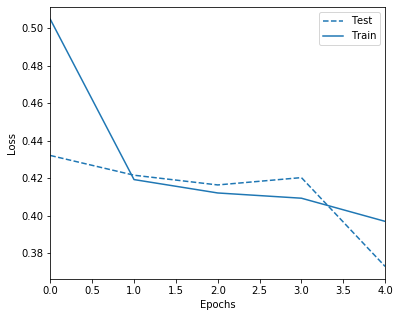

In [18]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train,
          pd.get_dummies(y_train),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
eval_model(model)

In [19]:
set(model.predict_classes(X_test)) ## 전부 0으로 예측을 함 . 데이터 편향 문제때문

{0}

In [20]:
# result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
# result['predict'] = model.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
# result[result.predict>0.3]


# 데이터 클래스 불균형 문제 해결하자

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## upsampling

In [22]:
up_X, up_y = RandomOverSampler().fit_resample(x_padded, datasets.label)
up_X_train, up_X_test, up_y_train, up_y_test = train_test_split(up_X, up_y)

In [23]:
# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(6026, 3013)

Train on 4519 samples, validate on 1507 samples
Epoch 1/5
4519/4519 [==============================] - ETA: 3:53 - loss: 0.0085 - acc: 1.000 - ETA: 58s - loss: 0.0255 - acc: 0.992 - ETA: 26s - loss: 0.0451 - acc: 0.99 - ETA: 15s - loss: 0.0720 - acc: 0.98 - ETA: 10s - loss: 0.0620 - acc: 0.98 - ETA: 8s - loss: 0.0530 - acc: 0.9878 - ETA: 7s - loss: 0.0472 - acc: 0.989 - ETA: 5s - loss: 0.0422 - acc: 0.990 - ETA: 4s - loss: 0.0520 - acc: 0.989 - ETA: 4s - loss: 0.0576 - acc: 0.988 - ETA: 3s - loss: 0.0543 - acc: 0.989 - ETA: 3s - loss: 0.0555 - acc: 0.989 - ETA: 3s - loss: 0.0553 - acc: 0.988 - ETA: 2s - loss: 0.0557 - acc: 0.988 - ETA: 2s - loss: 0.0567 - acc: 0.986 - ETA: 2s - loss: 0.0553 - acc: 0.987 - ETA: 1s - loss: 0.0557 - acc: 0.986 - ETA: 1s - loss: 0.0537 - acc: 0.986 - ETA: 1s - loss: 0.0549 - acc: 0.985 - ETA: 1s - loss: 0.0527 - acc: 0.985 - ETA: 0s - loss: 0.0514 - acc: 0.986 - ETA: 0s - loss: 0.0500 - acc: 0.986 - ETA: 0s - loss: 0.0488 - acc: 0.986 - ETA: 0s - loss: 0.0

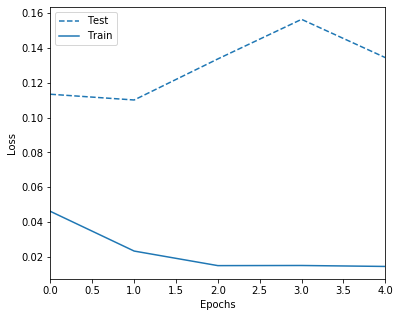

In [58]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(up_X_train,
          pd.get_dummies(up_y_train),
          epochs=5,
          validation_data=(up_X_test, pd.get_dummies(up_y_test))
         )
plot_loss(history)
test_loss, test_acc = model.evaluate(up_X_test, pd.get_dummies(up_y_test))
print('Test accuracy:', test_acc)

In [59]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, up_X_test))
result['predict'] = model.predict_proba(up_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)

전체채팅수1507, 유해채팅수763


,0,predict
0,개창/Noun 석/Noun 이/Josa <PAD> <PAD> <PAD> <PAD> ...,1.000000
1,어허/Exclamation 음란/Noun 성/Suffix 띡/Noun !/Punct...,0.999999
2,개창/Noun 석/Noun 아/Josa 나가/Verb 죽어줘/Verb 제발/Noun...,1.000000
4,응/Noun 브빡/Noun 이/Josa 브/Noun 사모/Noun 들/Verb ㄲㅈ...,0.999989
10,창석/Noun 이/Determiner 붕알/Noun 냄새/Noun 맞고싶다/Verb...,0.980256
13,창석/Noun 이/Determiner 붕알/Noun 냄새/Noun 맞고/Verb 파...,0.999984
14,콧털좀/Noun 짜르/Noun 자/Suffix 킁킁/Adverb 대는거/Verb 듣...,0.999997
15,이색기/Noun 팔로우/Noun 는/Josa 감사하다는말도/Verb 안/VerbPr...,0.999984
16,브베/Noun 형/Suffix 뮤직비디오/Noun 언제/Noun 만들어요/Verb ...,0.999739
18,취미/Noun 생활/Noun 할거면/Verb 방송/Noun 끄고하라고/Verb 씨발...,1.000000


In [60]:
result[(result.predict>0.1) & (result.predict<0.9)]

,0,predict
5,터프하/Noun 다/Josa <PAD> <PAD> <PAD> <PAD> <PAD> ...,0.252816
191,차라리/Noun 그게/Noun 낫/Noun 지/Josa <PAD> <PAD> <PA...,0.120460
275,지/Verb <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA...,0.760932
314,가슴/Noun 캠/Noun ?/Punctuation <PAD> <PAD> <PAD>...,0.435453
385,그러니/Adjective 하지마라/Verb <PAD> <PAD> <PAD> <PAD...,0.105374
476,아/Noun 나/Josa <PAD> <PAD> <PAD> <PAD> <PAD> <P...,0.545884
516,스마트/Noun 컴/Noun ?/Punctuation <PAD> <PAD> <PAD...,0.167683
519,본인/Noun 의/Josa 인생/Noun 처럼/Josa ?/Punctuation <...,0.557419
536,Squid/Alpha 1/Number <PAD> <PAD> <PAD> <PAD> <...,0.540295
550,미팅/Noun 넘/Verb <PAD> <PAD> <PAD> <PAD> <PAD> <...,0.680606


In [62]:
## 잘못 예측한 경우
result['label'] = up_y_test
result[model.predict_classes(up_X_test) != up_y_test]

,0,predict,label
117,야/Exclamation 브베/Noun 야/Josa <PAD> <PAD> <PAD>...,0.999796,0
124,ㄴ/KoreanParticle ㅈ/KoreanParticle <PAD> <PAD> ...,0.999806,0
259,그다음/Noun 에/Josa 브베/Noun 마냥/Noun 엄마/Noun 두드려/Ve...,0.986793,0
275,지/Verb <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PA...,0.760932,0
314,가슴/Noun 캠/Noun ?/Punctuation <PAD> <PAD> <PAD>...,0.435453,1
327,브베/Noun 양/Suffix ~/Punctuation 스타/Noun 하장/Noun...,0.977673,0
436,진짜/Noun 500/Number 개/Noun 충전/Noun 해놨으니까/Verb 오...,0.998547,0
475,빨리/Adverb 하라/Noun 고/Josa <PAD> <PAD> <PAD> <PA...,0.984778,0
476,아/Noun 나/Josa <PAD> <PAD> <PAD> <PAD> <PAD> <P...,0.545884,0
519,본인/Noun 의/Josa 인생/Noun 처럼/Josa ?/Punctuation <...,0.557419,0


## DownSampling

In [63]:
down_X, down_y = RandomUnderSampler().fit_resample(x_padded, datasets.label)
down_X_train, down_X_test, down_y_train, down_y_test = train_test_split(down_X, down_y)

In [64]:
# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(974, 487)

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 730 samples, validate on 244 samples
Epoch 1/5
730/730 [==============================] - ETA: 42s - loss: 0.0032 - acc: 1.00 - ETA: 4s - loss: 0.0195 - acc: 0.9955 - ETA: 2s - loss: 0.0520 - acc: 0.990 - ETA: 0s - loss: 0.0431 - acc: 0.988 - 3s 3ms/sample - loss: 0.0354 - acc: 0.9897 - val_loss: 0.0255 - val_acc: 0.9918
Epoch 2/5
730/730 [==============================] - ETA: 0s - loss: 2.2340e-04 - acc: 1.000 - ETA: 0s - loss: 0.0112 - acc: 0.9955    - ETA: 0s - loss: 0.0157 - acc: 0.991 - ETA: 0s - loss: 0.0260 - acc: 0.992 - 0s 327us/sample - loss: 0.0252 - acc: 0.9925 - val_loss: 0.0239 - val_acc: 0.9918
Epoch 3/5
730/730 [==============================] - ETA: 0s - loss: 0.0021 - acc: 1.000 - ETA: 0s - loss: 0.0160 - acc: 0.995 - ETA: 0s - loss: 0.0218 - acc: 0.994 - ETA: 0s - loss: 0.0191 - acc: 0.994 - ETA: 0s - loss: 0.0159 - acc: 0.995 - 0s 381us/sample - loss: 0.0192 - acc: 0.9945 - val_loss: 0.0247 - val_acc: 0.9877
Epoch 4/5
730/730 [=============================

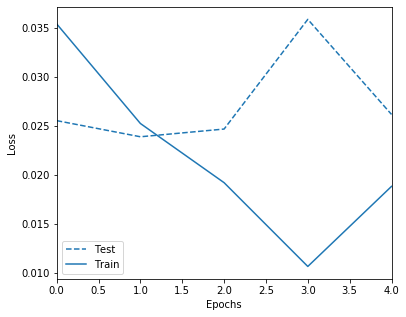

In [65]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(down_X_train,
          pd.get_dummies(down_y_train),
          epochs=5,
          validation_data=(down_X_test, pd.get_dummies(down_y_test))
         )
plot_loss(history)
test_loss, test_acc = model.evaluate(down_X_test, pd.get_dummies(down_y_test))
print('Test accuracy:', test_acc)

In [66]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, down_X_test), columns=['chat'])
result['predict'] = model.predict_proba(down_X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)

전체채팅수244, 유해채팅수121


,chat,predict
0,똥/Noun 싸고있네/Verb <PAD> <PAD> <PAD> <PAD> <PAD>...,0.999907
2,어디/Noun 건방지게/Adjective 팔/Noun 걸/Noun 치고/Josa 다...,0.999999
6,오빠/Noun 자세/Noun 가/Josa 왜/Noun 이렇게/Adverb 건방지/A...,0.999853
7,미띵/Noun <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P...,0.922935
9,아핡/Noun <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P...,0.997039
11,이/Determiner 새/Modifier 기/Noun 리액션/Noun 한결같네/A...,0.999999
13,브베/Noun 야/Josa 언제/Noun 자살/Noun 할래/Verb <PAD> <...,0.999937
16,시발/Noun 년/Noun 이/Josa <PAD> <PAD> <PAD> <PAD> ...,1.000000
20,브베/Noun 형/Suffix 하루/Noun 에/Josa 딸/Noun 몇번/Noun...,0.999997
22,이상한/Adjective 노래/Noun 좀/Noun 꺼주세요/Verb 씌발/Noun...,0.999999


- 우리는 다양한 비속어 표현에 집중하고 싶고 
- 또한 정확도가 더 높은 downsampling을 사용하자!

In [67]:
result.to_csv('../../data/cnn_result.csv', encoding='euc-kr')

## 분류 애매한 채팅들

In [68]:
result[(result.predict>0.1) & (result.predict<0.9)]

,chat,predict
85,ㄵ/KoreanParticle <PAD> <PAD> <PAD> <PAD> <PAD>...,0.500756
121,Squid/Alpha 1/Number <PAD> <PAD> <PAD> <PAD> <...,0.549082
167,객기/Noun 야/Josa !/Punctuation <PAD> <PAD> <PAD>...,0.802125
173,브베/Noun 야/Josa 방송/Noun 접자/Verb <PAD> <PAD> <PA...,0.499962
188,가슴/Noun 캠/Noun ?/Punctuation <PAD> <PAD> <PAD>...,0.325469
225,He/Alpha LOVE/Alpha pillow/Alpha He/Alpha LOVE...,0.853604


### 예측 실패한 채팅들

In [69]:
result['label'] = down_y_test
result[model.predict_classes(down_X_test) != down_y_test]

,chat,predict,label
33,메이플/Noun 이랑/Josa 카트/Noun 할/Verb 때/Noun 는/Josa ...,0.919183,0
188,가슴/Noun 캠/Noun ?/Punctuation <PAD> <PAD> <PAD>...,0.325469,1


# 시11111발 의 경우

In [106]:
test_chat = "시1111발"
test_id = text_to_index(morp.pos(test_chat, norm=True, join=True))
print(morp.pos(test_chat, norm=True, join=True))
sentence_size = 20
x_padded = sequence.pad_sequences([test_id],
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

['시/Noun', '1111/Number', '발/Noun']


In [115]:
model.predict(x_padded)

array([[0.36088392, 0.6328617 ]], dtype=float32)

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용